In [1]:
# Dependencies
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json
from scipy.stats import linregress
import numpy as np
from sklearn import datasets

# Read in the csv file with the information from Spotify.¶


In [3]:
# Pull in the first file Hot100 audio features found at Weekly Hot 100 singles chart between 8/2/1958 and 12/28/2019
# This file contains a list of songs containing the spotify attributes
hot100 = os.path.join("data", "Hot100AudioFeatures.csv")

# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
hot_100_df = pd.read_csv(hot100, encoding="ISO-8859-1")
hot_100_df.head()

,ï»¿SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),False,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,False,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,True,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,True,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


## Clean up the dataframe by removing some columns and eliminating rows that have no information.

In [4]:
# Drop the columns not needed for the analysis
hot100_clean_df = hot_100_df.drop(columns=['spotify_track_preview_url','spotify_track_album','spotify_track_explicit','spotify_track_duration_ms'],axis=1)

# Correct a header with questionable characters
hot100_clean_df.rename(columns = {'ï»¿SongID': 'SongID'},inplace=True)

# Drop any rows that have no information
hot100_clean_df.dropna(inplace=True)

#final dataframe that will be used.
hot100_clean_df


,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,91.0,0.734,0.836,10.0,-4.803,0.0,0.0735,0.017000,0.000016,0.1790,0.623,80.002,4.0
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,88.0,0.572,0.385,7.0,-6.362,1.0,0.0308,0.371000,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,86.0,0.542,0.674,6.0,-4.169,1.0,0.2100,0.058800,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,61.0,0.948,0.623,8.0,-5.725,0.0,0.1680,0.001240,0.000001,0.0716,0.856,135.979,4.0
5,The ArcherTaylor Swift,Taylor Swift,The Archer,"['dance pop', 'pop', 'post-teen pop']",3pHkh7d0lzM2AldUtz2x37,76.0,0.292,0.574,0.0,-9.375,1.0,0.0401,0.120000,0.005690,0.0663,0.166,124.344,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28486,"Tonight, Tonight, TonightGenesis",Genesis,"Tonight, Tonight, Tonight","['album rock', 'art rock', 'classic rock', 'me...",3qmYlsTbC9CD9SGoVmaEDa,42.0,0.571,0.502,7.0,-14.405,1.0,0.0303,0.015800,0.014000,0.0849,0.316,98.058,4.0
28487,"Tonight, TonightThe Smashing Pumpkins",The Smashing Pumpkins,"Tonight, Tonight","['alternative metal', 'alternative rock', 'gru...",7bu0znpSbTks0O6I98ij0W,69.0,0.287,0.670,6.0,-9.381,1.0,0.0368,0.000063,0.748000,0.2370,0.222,148.928,4.0
28488,Tonight's The Night (Gonna Be Alright)Rod Stewart,Rod Stewart,Tonight's The Night (Gonna Be Alright),"['adult standards', 'mellow gold', 'soft rock']",10LRRKPmx8uHcSxLVWK0ct,55.0,0.550,0.514,11.0,-12.617,1.0,0.0523,0.336000,0.125000,0.3820,0.724,136.542,3.0
28489,Tonight's The NightBLACKstreet,BLACKstreet,Tonight's The Night,"['boy band', 'dance pop', 'hip hop', 'hip pop'...",3scEwKiAkfdPUdZ6k1AEoW,32.0,0.585,0.573,6.0,-5.561,0.0,0.0759,0.133000,0.000011,0.1730,0.591,76.060,4.0


# Read in the csv file with the list of top 100 songs from 1958 to 2019

## Clean up the file by fixing column names and finding the highest that a song had made it in the top 100 billboards

In [5]:
# This is a large list of songs from 1958 to 2019 - Weekly Hot 100 singles chart between 8/2/1958 and 12/28/2019. 
# This was pulled from data world at https://data.world/kcmillersean/billboard-hot-100-1958-2017

hotstuff = os.path.join("data", "HotStuff.csv")

# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
hotstuff_df = pd.read_csv(hotstuff, encoding="ISO-8859-1")

# Rename the URL column
hotstuff_df.rename(columns = {'ï»¿url':'URL'},inplace=True)

# This is the final dataframe to be merged with the earlier dataframe
hotstuff_df


,URL,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,http://www.billboard.com/charts/hot-100/1995-1...,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,http://www.billboard.com/charts/hot-100/1997-1...,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,http://www.billboard.com/charts/hot-100/2006-0...,7/1/2006,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,http://www.billboard.com/charts/hot-100/2009-1...,10/24/2009,1,3,Britney Spears,3Britney Spears,1,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...
320490,https://www.billboard.com/charts/hot-100/2019-...,1/5/2019,8,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,13.0,8,25
320491,https://www.billboard.com/charts/hot-100/2019-...,12/7/2019,47,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,NaN,47,26
320492,https://www.billboard.com/charts/hot-100/2019-...,12/14/2019,23,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,47.0,23,27
320493,https://www.billboard.com/charts/hot-100/2019-...,12/21/2019,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,23.0,15,28


In [6]:
# Before we can use the top 100 list of songs we need tp only pull in one record of the song with the highest position in the
# top 100 list.
# Group by song to get the highest position in the top 100 list ( which mins the minimum) and create a dataframe out of it.

hotstuff_song = hotstuff_df.groupby('SongID')
hotstuff_clean = pd.DataFrame(hotstuff_song['Peak Position'].min())

# merge this with the earlier spotify dataframe to give us the main dataframe to work from.  
hotstuff_merge = pd.merge(hotstuff_clean , hot100_clean_df, how='inner', on='SongID')

# Clear out any fows with missing data
hotstuff_merge.dropna(inplace=True)

# This is the final dataframe to be used in the analysis for the attributes.
hotstuff_merge

,SongID,Peak Position,Performer,Song,spotify_genre,spotify_track_id,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"""B"" GirlsYoung And Restless",54,Young And Restless,"""B"" Girls",[],0rWUHulFlScxQsCq7kWKde,20.0,0.615,0.497,7.0,-11.913,1.0,0.4390,0.0160,0.000000,0.3120,0.769,193.762,3.0
1,"""Cherry Cherry"" from Hot August NightNeil Diamond",31,Neil Diamond,"""Cherry Cherry"" from Hot August Night","['adult standards', 'brill building pop', 'fol...",18ocy9Be9SxWEEnOLGDfkS,16.0,0.340,0.948,9.0,-5.061,1.0,0.1370,0.0941,0.000907,0.8670,0.604,172.349,4.0
2,#1 Dee JayGoody Goody,82,Goody Goody,#1 Dee Jay,['pop rap'],1tU3tJHbokVFAwD11zMuv7,0.0,0.859,0.376,7.0,-16.542,0.0,0.0439,0.0536,0.096300,0.0605,0.902,127.202,4.0
3,#1Nelly,22,Nelly,#1,"['dance pop', 'hip hop', 'pop', 'pop rap', 'ra...",7rSj5gEdN5KgHwbnEVAZ4b,50.0,0.792,0.600,7.0,-6.157,1.0,0.2280,0.0236,0.000000,0.4190,0.463,89.985,4.0
4,#9 DreamJohn Lennon,9,John Lennon,#9 Dream,"['album rock', 'classic rock', 'folk rock', 'm...",4ZVWvCUwsOnIGmJMj71RkG,55.0,0.406,0.597,0.0,-11.745,1.0,0.0336,0.0744,0.013300,0.2540,0.478,115.474,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23559,idontwannabeyouanymoreBillie Eilish,96,Billie Eilish,idontwannabeyouanymore,"['electropop', 'pop']",41zXlQxzTi6cGAjpOXyLYH,86.0,0.483,0.412,7.0,-8.461,1.0,0.0402,0.7370,0.000000,0.1160,0.247,170.163,3.0
23560,sobeautifulMusiq Soulchild,84,Musiq Soulchild,sobeautiful,"['alternative r&b', 'dance pop', 'neo soul', '...",2PN3gbuBn5WBEwrEJH3xiu,59.0,0.689,0.562,7.0,-7.048,0.0,0.0637,0.0656,0.000000,0.0885,0.210,133.987,4.0
23561,teachmeMusiq Soulchild,42,Musiq Soulchild,teachme,"['alternative r&b', 'dance pop', 'neo soul', '...",0ODFPypnJLE6hKgahiuSzn,57.0,0.499,0.610,8.0,-5.110,0.0,0.1350,0.4730,0.000000,0.0722,0.436,172.969,3.0
23562,whoa (mind in awe)XXXTENTACION,37,XXXTENTACION,whoa (mind in awe),"['emo rap', 'miami hip hop']",7pdF27mSDuPWhppnHAmWHa,77.0,0.735,0.525,6.0,-2.939,0.0,0.0441,0.6530,0.918000,0.1010,0.369,160.147,4.0


In [39]:
# show the count of the data in the merged dataframe
for x in range(1,101):
    y = hotstuff_merge.loc[hotstuff_merge['Peak Position'] == x,'Song'].count()
    print(f'Peak position {x} has {y} songs')

Peak position 1 has 967 songs
Peak position 2 has 443 songs
Peak position 3 has 446 songs
Peak position 4 has 383 songs
Peak position 5 has 386 songs
Peak position 6 has 355 songs
Peak position 7 has 372 songs
Peak position 8 has 340 songs
Peak position 9 has 334 songs
Peak position 10 has 344 songs
Peak position 11 has 288 songs
Peak position 12 has 296 songs
Peak position 13 has 276 songs
Peak position 14 has 276 songs
Peak position 15 has 249 songs
Peak position 16 has 236 songs
Peak position 17 has 245 songs
Peak position 18 has 234 songs
Peak position 19 has 214 songs
Peak position 20 has 268 songs
Peak position 21 has 249 songs
Peak position 22 has 228 songs
Peak position 23 has 237 songs
Peak position 24 has 204 songs
Peak position 25 has 228 songs
Peak position 26 has 218 songs
Peak position 27 has 225 songs
Peak position 28 has 234 songs
Peak position 29 has 225 songs
Peak position 30 has 211 songs
Peak position 31 has 208 songs
Peak position 32 has 211 songs
Peak position 33 

In [7]:
#Adding function to plot information in a scatter plot
# inputs
#      xvalues = this is the x value series to be plotted
#      yvalues = This is the y value series to be plotted
#      x_loc = This is where we want the slope line to be displayed on the x axis
#      y_loc = This is where we want the slope line to be displayed on the y axis
#      x_label = Label for the x axis
#      y_label = Label for the y axis
#      title = Label for the Title of the plot

def plot_func(xvalues,yvalues,x_loc,y_loc,x_label,y_label,title):
    
    # Generate the pearson coeeficient
    correlation = sts.pearsonr(xvalues,yvalues)
    
    # display the information to the screen
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    print(f"The p-value is {round(correlation[1],3)}")

    # Get the linear regression model
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)

    # Create the line using the slope and intercept and print out the formula
    regress_values = xvalues * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot information
    plt.scatter(xvalues,yvalues)
    plt.plot(xvalues,regress_values,"r-")
    plt.annotate(line_eq,(x_loc,y_loc),fontsize=15,color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


The correlation between both factors is -0.33
The p-value is 0.0


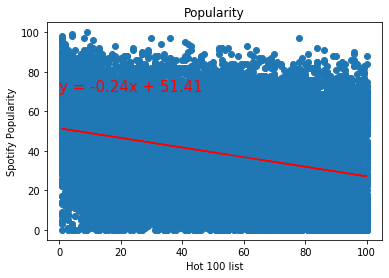

In [9]:
# create a scatter plot based on the peak ranking versus the spotify track popularity.  
# We need to repeat this for the other factors

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['spotify_track_popularity'],0,70,'Hot 100 list',
          'Spotify Popularity','Popularity')


The correlation between both factors is -0.05
The p-value is 0.0


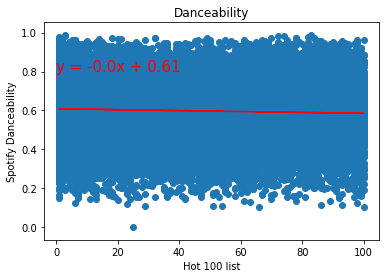

In [10]:
# create a scatter plot based on the peak ranking versus the danceability.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['danceability'],0,.8,'Hot 100 list',
          'Spotify Danceability','Danceability')


The correlation between both factors is 0.02
The p-value is 0.0


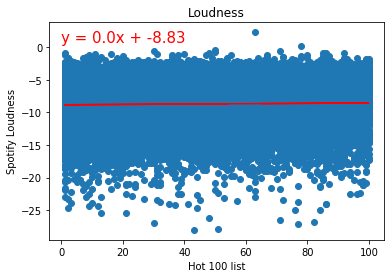

In [11]:
# create a scatter plot based on the peak ranking versus the loudness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['loudness'],0,.8,'Hot 100 list',
          'Spotify Loudness','Loudness')

The correlation between both factors is 0.01
The p-value is 0.111


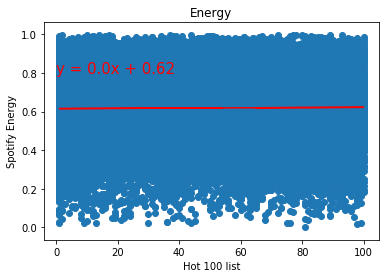

In [12]:
# create a scatter plot based on the peak ranking versus the Energy.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['energy'],0,.8,'Hot 100 list',
          'Spotify Energy','Energy')

The correlation between both factors is 0.05
The p-value is 0.0


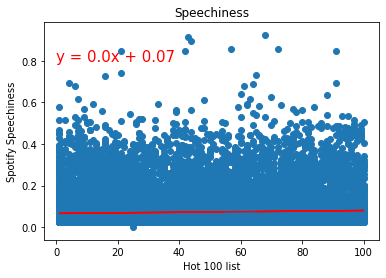

In [13]:
# create a scatter plot based on the peak ranking versus the Speechiness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['speechiness'],0,.8,'Hot 100 list',
          'Spotify Speechiness','Speechiness')


The correlation between both factors is 0.03
The p-value is 0.0


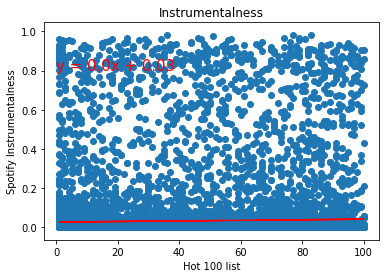

In [14]:
# create a scatter plot based on the peak ranking versus the Instrumentalness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['instrumentalness'],0,.8,'Hot 100 list',
          'Spotify Instrumentalness','Instrumentalness')


The correlation between both factors is 0.02
The p-value is 0.004


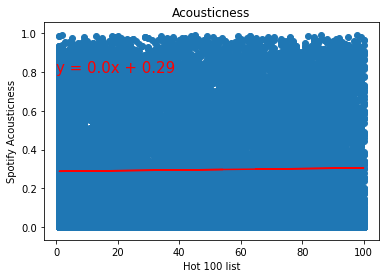

In [15]:
# create a scatter plot based on the peak ranking versus the acousticness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['acousticness'],0,.8,'Hot 100 list',
          'Spotify Acousticness','Acousticness')

The correlation between both factors is -0.05
The p-value is 0.0


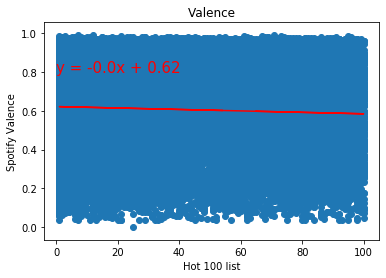

In [16]:
# create a scatter plot based on the peak ranking versus the Valence.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['valence'],0,.8,'Hot 100 list',
          'Spotify Valence','Valence')

The correlation between both factors is 0.02
The p-value is 0.002


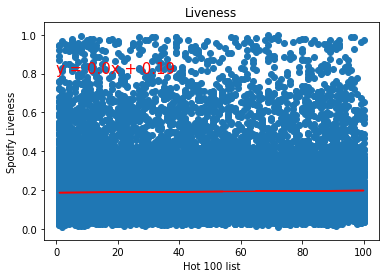

In [17]:
# create a scatter plot based on the peak ranking versus the Liveness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['liveness'],0,.8,'Hot 100 list',
          'Spotify Liveness','Liveness')

The correlation between both factors is 0.01
The p-value is 0.199


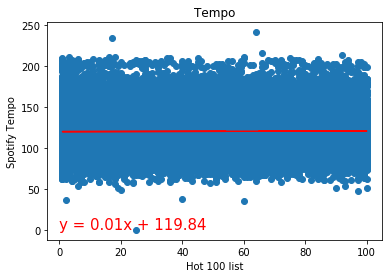

In [18]:
# create a scatter plot based on the peak ranking versus the Tempo.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['tempo'],0,.8,'Hot 100 list',
          'Spotify Tempo','Tempo')

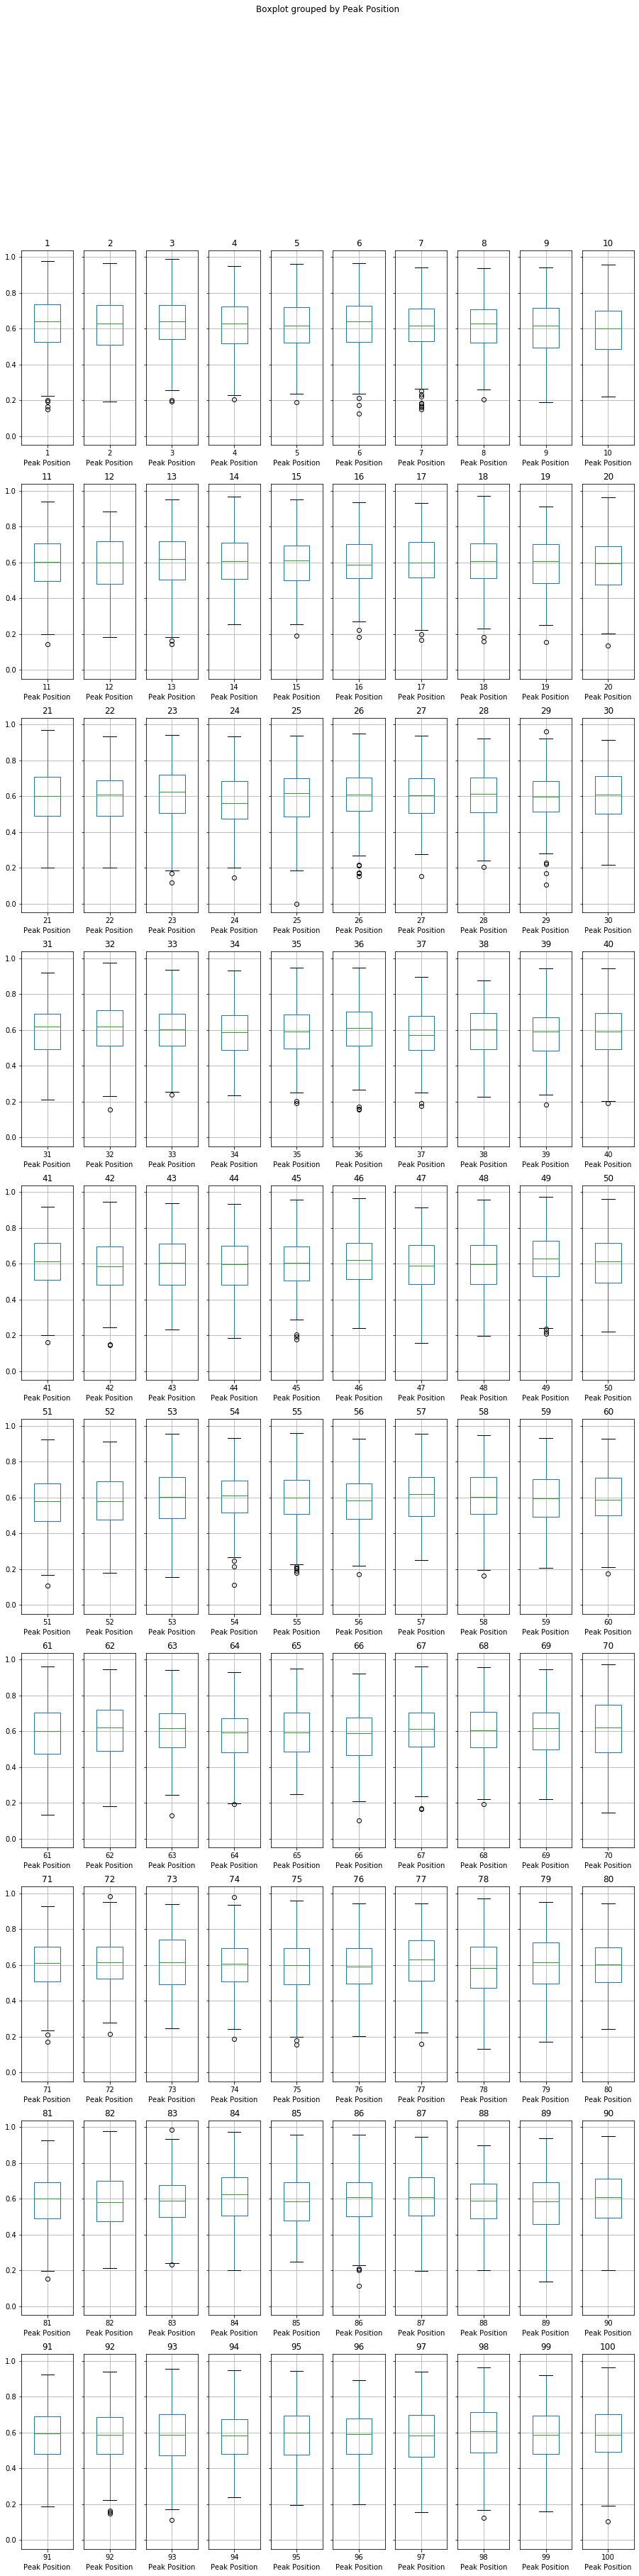

In [21]:
# Plot the information for all four Regimens
peak_plot = hot100_stat_group.boxplot(by ='Peak Position', column =['danceability'], grid = True,widths=0.5,figsize=(15,60)) 
hot100_stat_group.set_ylabel = 'Danceability'
plt.show()

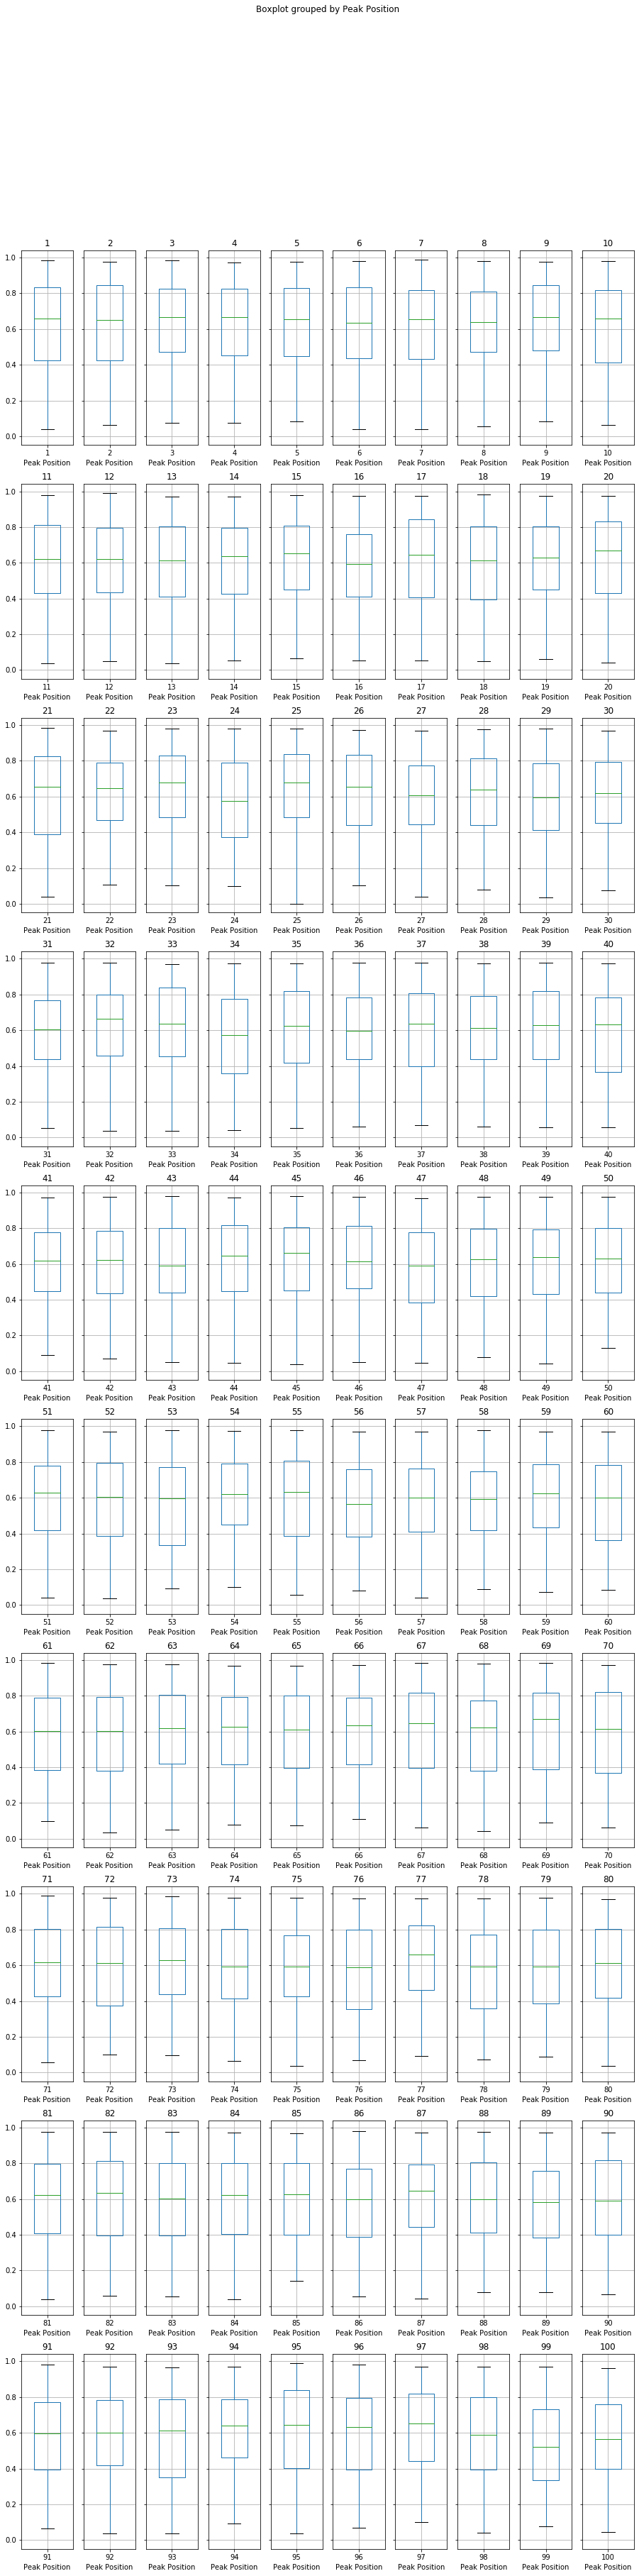

In [22]:
# Plot the information for all four Regimens
peak_plot = hot100_stat_group.boxplot(by ='Peak Position', column =['valence'], grid = True,widths=0.5,figsize=(15,60)) 
hot100_stat_group.set_ylabel = 'Valence'
plt.show()

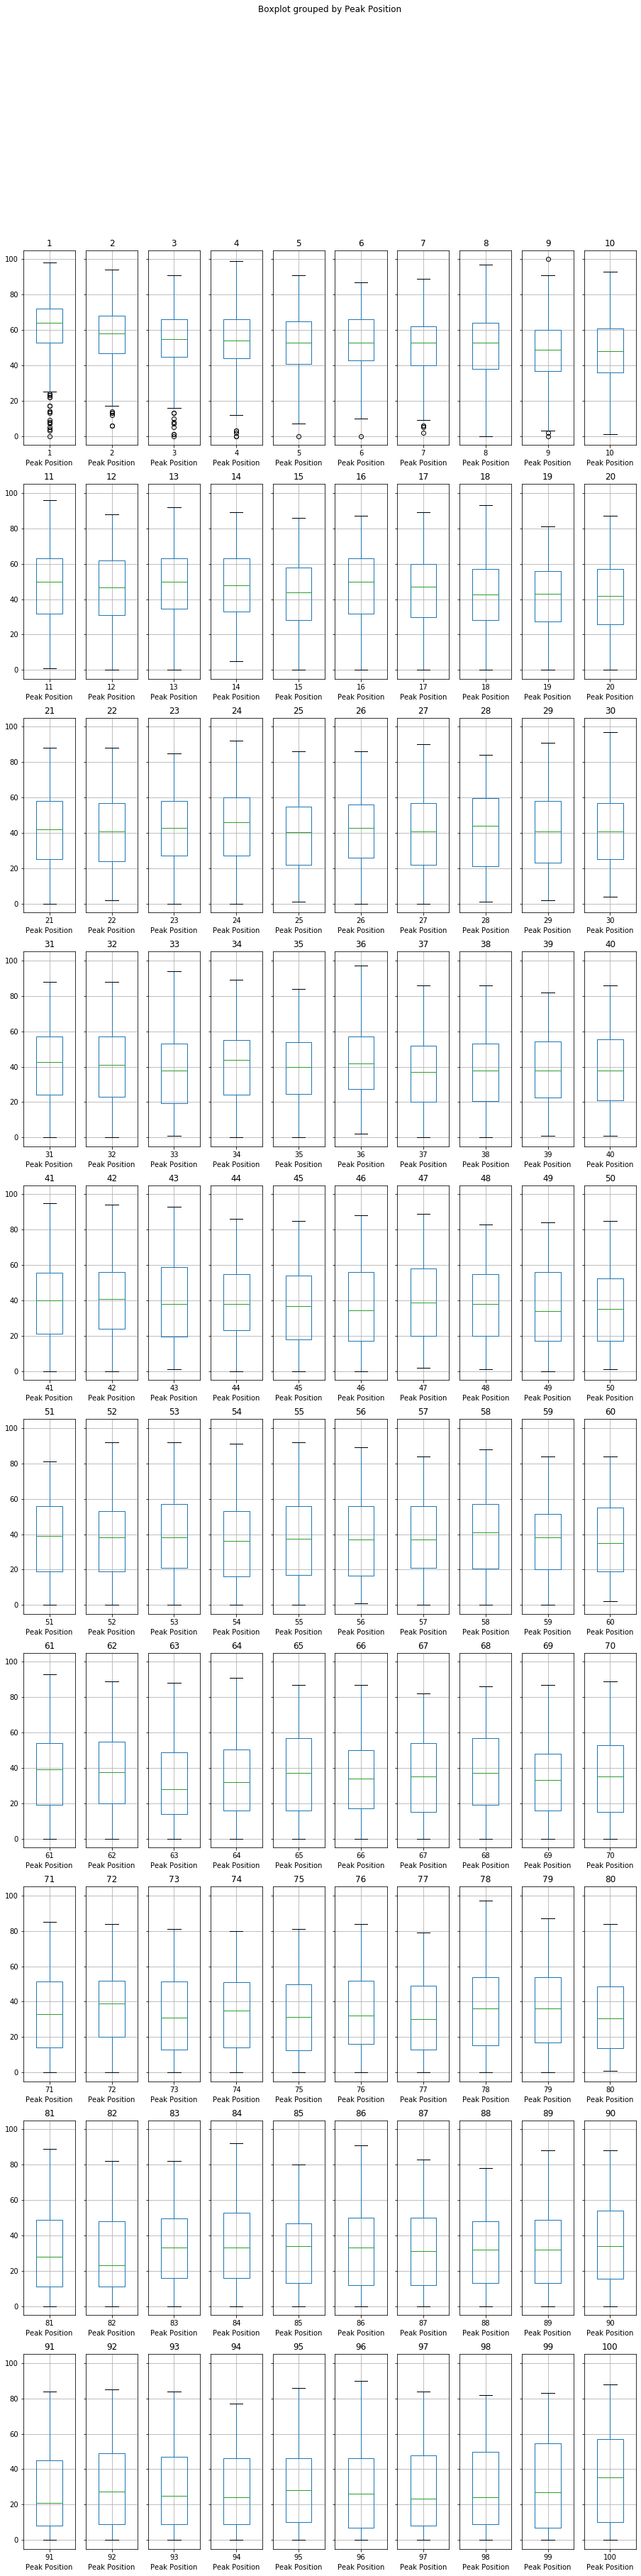

In [9]:
# Plot the information for all four Regimens
peak_plot = hot100_stat_group.boxplot(by ='Peak Position', column =['spotify_track_popularity'], grid = True,widths=0.5,figsize=(15,60)) 
hot100_stat_group.set_ylabel = 'Spotify_track_popularity'
plt.show()

In [8]:
# Wanted to look at the mean and median to see if there are any trend from that perspective.
# Take a copy of the file
hot100_stat = hotstuff_merge.copy()

# Drop out some additional columns
hot100_stat.drop(columns=['key','mode','time_signature'],inplace=True)

# groupby the Peak Position of the song
hot100_stat_group = hot100_stat.groupby("Peak Position")

#grap the mean and median
group_mean = hot100_stat_group.mean()
group_median = hot100_stat_group.median()

# Put into a dataframe and merge them together.
mean_df = pd.DataFrame(hot100_stat_group.mean())
median_df = pd.DataFrame(hot100_stat_group.median())
hot100_stat_merge = pd.merge(mean_df,median_df,how='inner',on='Peak Position',suffixes=('_Mean','_Median'))

# Look at the final merge
hot100_stat_merge

,spotify_track_popularity_Mean,danceability_Mean,energy_Mean,loudness_Mean,speechiness_Mean,acousticness_Mean,instrumentalness_Mean,liveness_Mean,valence_Mean,tempo_Mean,spotify_track_popularity_Median,danceability_Median,energy_Median,loudness_Median,speechiness_Median,acousticness_Median,instrumentalness_Median,liveness_Median,valence_Median,tempo_Median
Peak Position,,,,,,,,,,,,,,,,,,,,
1,61.791107,0.627081,0.601487,-8.850642,0.065071,0.302880,0.026558,0.167359,0.620902,117.984368,64.0,0.6410,0.6090,-8.4120,0.04000,0.2100,0.000005,0.118,0.660,115.6410
2,57.056433,0.613797,0.603938,-8.874273,0.059663,0.312942,0.032345,0.193806,0.625490,119.727524,58.0,0.6300,0.6210,-8.4570,0.04040,0.2180,0.000005,0.136,0.651,118.8140
3,54.004484,0.632946,0.613989,-8.862085,0.064889,0.302304,0.032167,0.178710,0.641024,120.555439,55.0,0.6415,0.6345,-8.6660,0.03970,0.2245,0.000006,0.124,0.667,119.8630
4,54.315927,0.615256,0.614150,-8.765561,0.070650,0.290391,0.028132,0.183170,0.629037,118.969311,54.0,0.6300,0.6370,-8.2440,0.04150,0.2110,0.000007,0.126,0.668,116.7820
5,52.505181,0.612676,0.615228,-9.000951,0.058917,0.278690,0.016833,0.176052,0.633301,118.627389,53.0,0.6180,0.6220,-8.5485,0.03775,0.1800,0.000007,0.115,0.655,118.6300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,29.400000,0.581648,0.632511,-8.525988,0.073455,0.330310,0.057183,0.214309,0.612884,119.766352,26.0,0.5910,0.6630,-8.0620,0.04300,0.2380,0.000004,0.150,0.631,118.0440
97,28.463918,0.572990,0.614471,-8.354005,0.082290,0.348976,0.044318,0.202906,0.624387,121.468598,23.5,0.5825,0.6035,-8.1895,0.04240,0.3070,0.000003,0.139,0.654,119.7775
98,29.573770,0.594590,0.588438,-8.823219,0.082152,0.339260,0.045550,0.184086,0.590123,120.077628,24.0,0.6060,0.6120,-8.1700,0.04430,0.2700,0.000002,0.128,0.588,117.5830


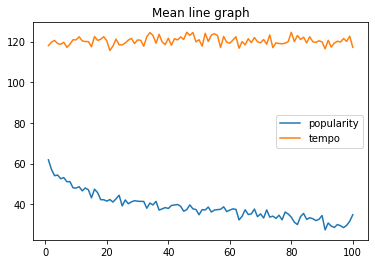

<Figure size 432x288 with 0 Axes>

In [49]:
# Plot the mean lines to see if we see anything special.
# Create our x_axis list
x_axis = np.arange(1, 101, 1)
plt.plot(x_axis, hot100_stat_merge['spotify_track_popularity_Mean'],label="popularity")
plt.plot(x_axis, hot100_stat_merge['tempo_Mean'],label="tempo")
plt.legend(loc="best")
plt.title('Mean line graph')
plt.show()
# Saves an image of our chart so that we can view it in a folder
plt.savefig("Images/Meangraph1.png")

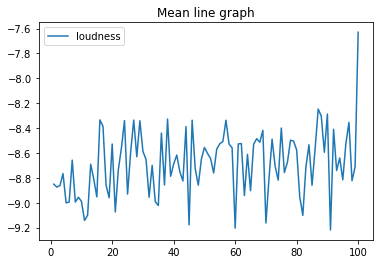

<Figure size 432x288 with 0 Axes>

In [50]:
# Plot the mean lines to see if we see anything special.
# Create our x_axis list
x_axis = np.arange(1, 101, 1)

plt.plot(x_axis, hot100_stat_merge['loudness_Mean'],label="loudness")

plt.legend(loc="best")
plt.title('Mean line graph')
plt.show()
# Saves an image of our chart so that we can view it in a folder
plt.savefig("Images/Meangraphval.png")

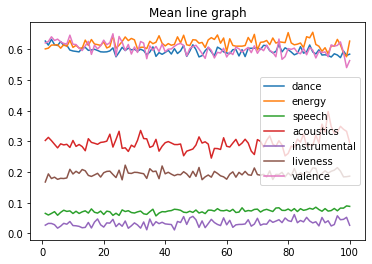

<Figure size 432x288 with 0 Axes>

In [51]:
# Plot the mean lines to see if we see anything special.
# Create our x_axis list
x_axis = np.arange(1, 101, 1)
plt.plot(x_axis, hot100_stat_merge['danceability_Mean'],label="dance")
plt.plot(x_axis, hot100_stat_merge['energy_Mean'],label="energy")
plt.plot(x_axis, hot100_stat_merge['speechiness_Mean'],label="speech")
plt.plot(x_axis, hot100_stat_merge['acousticness_Mean'],label="acoustics")
plt.plot(x_axis, hot100_stat_merge['instrumentalness_Mean'],label="instrumental")
plt.plot(x_axis, hot100_stat_merge['liveness_Mean'],label="liveness")
plt.plot(x_axis, hot100_stat_merge['valence_Mean'],label="valence")

plt.legend(loc="best")
plt.title('Mean line graph')
plt.show()
# Saves an image of our chart so that we can view it in a folder
plt.savefig("Images/Meangraph2.png")

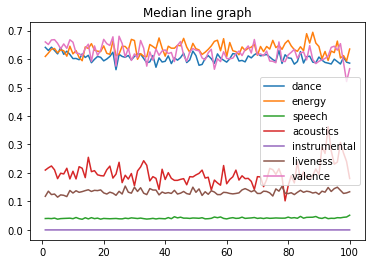

<Figure size 432x288 with 0 Axes>

In [52]:
# Plot the median lines to see if we see anything special.

# Create our x_axis list
x_axis = np.arange(1, 101, 1)
plt.plot(x_axis, hot100_stat_merge['danceability_Median'],label="dance")
plt.plot(x_axis, hot100_stat_merge['energy_Median'],label="energy")
plt.plot(x_axis, hot100_stat_merge['speechiness_Median'],label="speech")
plt.plot(x_axis, hot100_stat_merge['acousticness_Median'],label="acoustics")
plt.plot(x_axis, hot100_stat_merge['instrumentalness_Median'],label="instrumental")
plt.plot(x_axis, hot100_stat_merge['liveness_Median'],label="liveness")
plt.plot(x_axis, hot100_stat_merge['valence_Median'],label="valence")
plt.legend(loc="best")
plt.title('Median line graph')
plt.show()
# Saves an image of our chart so that we can view it in a folder
plt.savefig("Images/Mediangraph2.png")

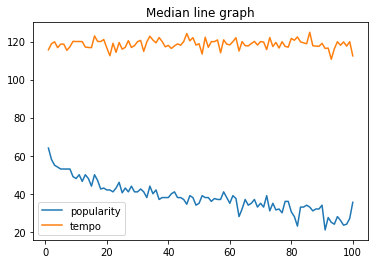

<Figure size 432x288 with 0 Axes>

In [53]:
# Plot the median lines to see if we see anything special.

# Create our x_axis list
x_axis = np.arange(1, 101, 1)
plt.plot(x_axis, hot100_stat_merge['spotify_track_popularity_Median'],label="popularity")
plt.plot(x_axis, hot100_stat_merge['tempo_Median'],label="tempo")
plt.legend(loc="best")
plt.title('Median line graph')
plt.show()
# Saves an image of our chart so that we can view it in a folder
plt.savefig("Images/Mediangraph1.png")

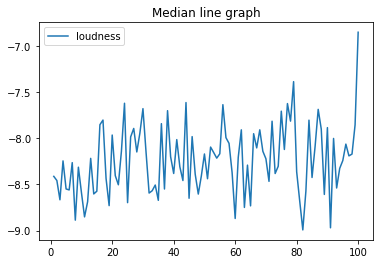

<Figure size 432x288 with 0 Axes>

In [54]:
# Plot the median lines to see if we see anything special.

# Create our x_axis list
x_axis = np.arange(1, 101, 1)

plt.plot(x_axis, hot100_stat_merge['loudness_Median'],label="loudness")

plt.legend(loc="best")
plt.title('Median line graph')
plt.show()
# Saves an image of our chart so that we can view it in a folder
plt.savefig("Images/Mediangraphval.png")

In [29]:
# Try t-test, but not sure I have the data right.  Need to compare the 1 position to another set of
# information.

from scipy.stats import ttest_ind

cat1 = hotstuff_merge[hotstuff_merge['Peak Position']== 1]
cat2 = hotstuff_merge[hotstuff_merge['Peak Position']== 2]

ttest_ind(cat1['spotify_track_popularity'], cat100['spotify_track_popularity'])


Ttest_indResult(statistic=17.72291005384624, pvalue=5.495752821774584e-62)

In [35]:
# Here are the z-scores for songs at peak position 1.
cols = ['spotify_track_popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# create a new dataframe which will store the z-scores for songs at Peak Position 1
df=pd.DataFrame()

#loop through all the columns to create the new column and create the score
for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (cat1[col] - cat1[col].mean()) /cat1[col].std(ddof=0)
df

,spotify_track_popularity_zscore,danceability_zscore,energy_zscore,loudness_zscore,speechiness_zscore,acousticness_zscore,instrumentalness_zscore,liveness_zscore,valence_zscore,tempo_zscore
24,-1.000230,-0.550013,1.533450,0.729587,-0.369217,-0.966445,-0.215573,-0.798790,0.943028,0.132462
32,0.216997,-0.707009,-1.171019,-1.101481,-0.525379,-0.799517,-0.215194,-0.766526,-1.300764,0.510725
42,-1.473597,0.064887,-0.374986,-0.709130,-0.462341,1.593835,-0.215573,-0.400365,0.326690,0.263088
46,1.096106,0.640539,1.283415,0.293577,-0.426524,-0.968613,0.815274,0.214905,1.140417,0.705679
53,0.555116,0.032180,0.640465,-0.686427,-0.304746,-1.051354,-0.214953,-0.747017,-0.491065,0.267446
...,...,...,...,...,...,...,...,...,...,...
23365,-0.864983,0.248049,0.140394,-1.164642,-0.300448,-0.956689,-0.215423,-0.777781,0.947056,0.242223
23370,0.960859,0.208800,0.390430,0.195198,-0.483831,-0.527086,-0.215518,-0.667483,0.105131,-0.455024
23383,0.893235,0.856409,0.053647,-0.742893,-0.075517,-0.079055,-0.192196,-0.539927,0.810092,-0.425752
23407,0.487492,0.444294,-1.630268,-1.894333,-0.509620,1.366206,0.001149,-0.680238,-0.708596,-1.014434


# This section looks at creating the list of Genres from the datafile.

In [10]:
# The spotify genre is a text field that looks like a list.  The way we converted it is through a search of the text
# field creating a dictionary which we can analyze and eventually narrow down.  

# Start with a blank dictionary
genre_dict ={}

# Loop through the dataframe hitting every row
for x in range(len(hotstuff_merge)):
    
    # Pull the field containing the Spotify Genre
    listfield = hotstuff_merge.loc[x,'spotify_genre']
    
    # We need to strip out unwanted characters.  Starting from an empty string to start with
    result_str = ""
    
    # For the string field step through each character and drop '  [ and ].  This will give a , comma separate list
    # which we place in result_str
    for i in range(0, len(listfield)): 
        if (listfield[i] != '[') and (listfield[i] != ']') and (listfield[i] != "'"): 
            result_str = result_str + listfield[i] 
    
    # If there is a genre recorded pull it out into a list
    # initialize a new field to place the comma separate list into
    newfield = []
    
    if len(result_str) != 0:
        newfield = result_str.split(",")
        
        # loop through the new list and place into a dictionary counting the number of occurences
        for g in newfield:

            if g in genre_dict:
                genre_dict[g] = genre_dict[g] + 1
            else:
                genre_dict[g] = 1

#print(genre_dict)
# place into a dataframe to display and later saved to disk
dict_df = pd.DataFrame(list(genre_dict.items()),columns=['Genre','count'])

dict_df


,Genre,count
0,adult standards,3198
1,brill building pop,1969
2,folk,1039
3,folk rock,2330
4,mellow gold,3620
...,...,...
1372,progressive psytrance,1
1373,euro hi-nrg,1
1374,west coast rap,1
1375,post-disco soul,1


In [11]:
# save the file to be shared
dict_df.to_csv('data/genrefile.csv')

# This section can be used if we want to pull in recent data (2020).

In [12]:
# There is an API that exists where we can get the same spotify attribute information as long as you have a track id.  
# There is also an URL https://spotifycharts.com/regional that provides top 200 information that we can slice and dice by
# day, and country.  This will be used for examing the comparison between US and the globe.
# access the URL above and pull down the csv file.  Below is example of on of teh files.

# After pulling file from spotify chart. skip the first row and import the csv file into a dataframe.  Also split out the
# Track identifier which will be used in the next cell.

july15 = os.path.join("data", "july15.csv")

# Read our Data file with the pandas library
# skip the first row since it has an information not associated to the data
july15_df = pd.read_csv(july15, encoding="ISO-8859-1", skiprows=1)

# Pull the trackid from the URL
july15_df[['Base URL','Track Identifier']] = july15_df.URL.str.split("track/",expand=True,)
july15_df.head()

,Position,Track Name,Artist,Streams,URL,Base URL,Track Identifier
0,1,ROCKSTAR (feat. Roddy Ricch),DaBaby,5287167,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,https://open.spotify.com/,7ytR5pFWmSjzHJIeQkgog4
1,2,Savage Love (Laxed - Siren Beat),Jawsh 685,4847209,https://open.spotify.com/track/1xQ6trAsedVPCdb...,https://open.spotify.com/,1xQ6trAsedVPCdbtDAmk0c
2,3,Blinding Lights,The Weeknd,4357126,https://open.spotify.com/track/0VjIjW4GlUZAMYd...,https://open.spotify.com/,0VjIjW4GlUZAMYd2vXMi3b
3,4,Come & Go (with Marshmello),Juice WRLD,4031110,https://open.spotify.com/track/7y7w4tl4MaRC2UM...,https://open.spotify.com/,7y7w4tl4MaRC2UMEj1mPtr
4,5,Watermelon Sugar,Harry Styles,3825086,https://open.spotify.com/track/6UelLqGlWMcVH1E...,https://open.spotify.com/,6UelLqGlWMcVH1E5c4H7lY


In [13]:
# Create an empty dataframe to pull in the current top 100.
july_df = pd.DataFrame()

# This code steps through the dataframe and pulls the information from Spotify.  
# Below in another cell, I display an example of the JSON file returned.

# set up the credentials to call the Spotify API
client_credentials_manager = SpotifyClientCredentials(client_id='09b1d71bfca845e9b744f70294704da2',
                           client_secret='581c60a4f6c347be9a749bf0a1bb5634')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# loop through a dataframe that has a column called Track Identified.  See above cell if you want to pull the file from the
# Regional URL https://spotifycharts.com/regional.

for row_index,row in july15_df.iterrows():

    # call the API specifically aduio_features given the Track Identifier from the dataframe provided
    if len(sys.argv) > 1:
        features = sp.audio_features(row['Track Identifier'])
        
#    print(f'Track Name {row["Track Name"]} danceability is: {features[0]["danceability"]}')

    # Add to the new dataframe being creaetd (In this case july_df) and append the informtion to the empty DataFrame
    july_df = july_df.append(features[0],ignore_index=True)
    
    # we only want 100
    if row_index >= 99:
        break
       


In [14]:
july_df.drop(columns=['analysis_url','duration_ms','id','key','mode','time_signature','track_href','type','uri'],inplace=True)
july_df

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.24700,0.746,0.690,0.000000,0.1010,-7.956,0.1640,89.977,0.497
1,0.23400,0.767,0.481,0.000000,0.2690,-8.520,0.0803,150.076,0.761
2,0.00146,0.514,0.730,0.000095,0.0897,-5.934,0.0598,171.005,0.334
3,0.01720,0.625,0.814,0.000000,0.1580,-5.181,0.0657,144.991,0.535
4,0.12200,0.548,0.816,0.000000,0.3350,-4.209,0.0465,95.390,0.557
...,...,...,...,...,...,...,...,...,...
95,0.86600,0.464,0.473,0.000000,0.1090,-10.086,0.1290,75.801,0.604
96,0.18500,0.544,0.744,0.000000,0.3360,-5.007,0.0889,73.699,0.572
97,0.16200,0.760,0.658,0.000000,0.1950,-5.275,0.2750,100.202,0.565
98,0.00815,0.688,0.647,0.000017,0.0950,-7.258,0.1900,88.834,0.195


# Example output from API call to spotify
[
    {
        "danceability": 0.746,
        "energy": 0.69,
        "key": 11,
        "loudness": -7.956,
        "mode": 1,
        "speechiness": 0.164,
        "acousticness": 0.247,
        "instrumentalness": 0,
        "liveness": 0.101,
        "valence": 0.497,
        "tempo": 89.977,
        "type": "audio_features",
        "id": "7ytR5pFWmSjzHJIeQkgog4",
        "uri": "spotify:track:7ytR5pFWmSjzHJIeQkgog4",
        "track_href": "https://api.spotify.com/v1/tracks/7ytR5pFWmSjzHJIeQkgog4",
        "analysis_url": "https://api.spotify.com/v1/audio-analysis/7ytR5pFWmSjzHJIeQkgog4",
        "duration_ms": 181733,
        "time_signature": 4
    }
]